using known PFRs

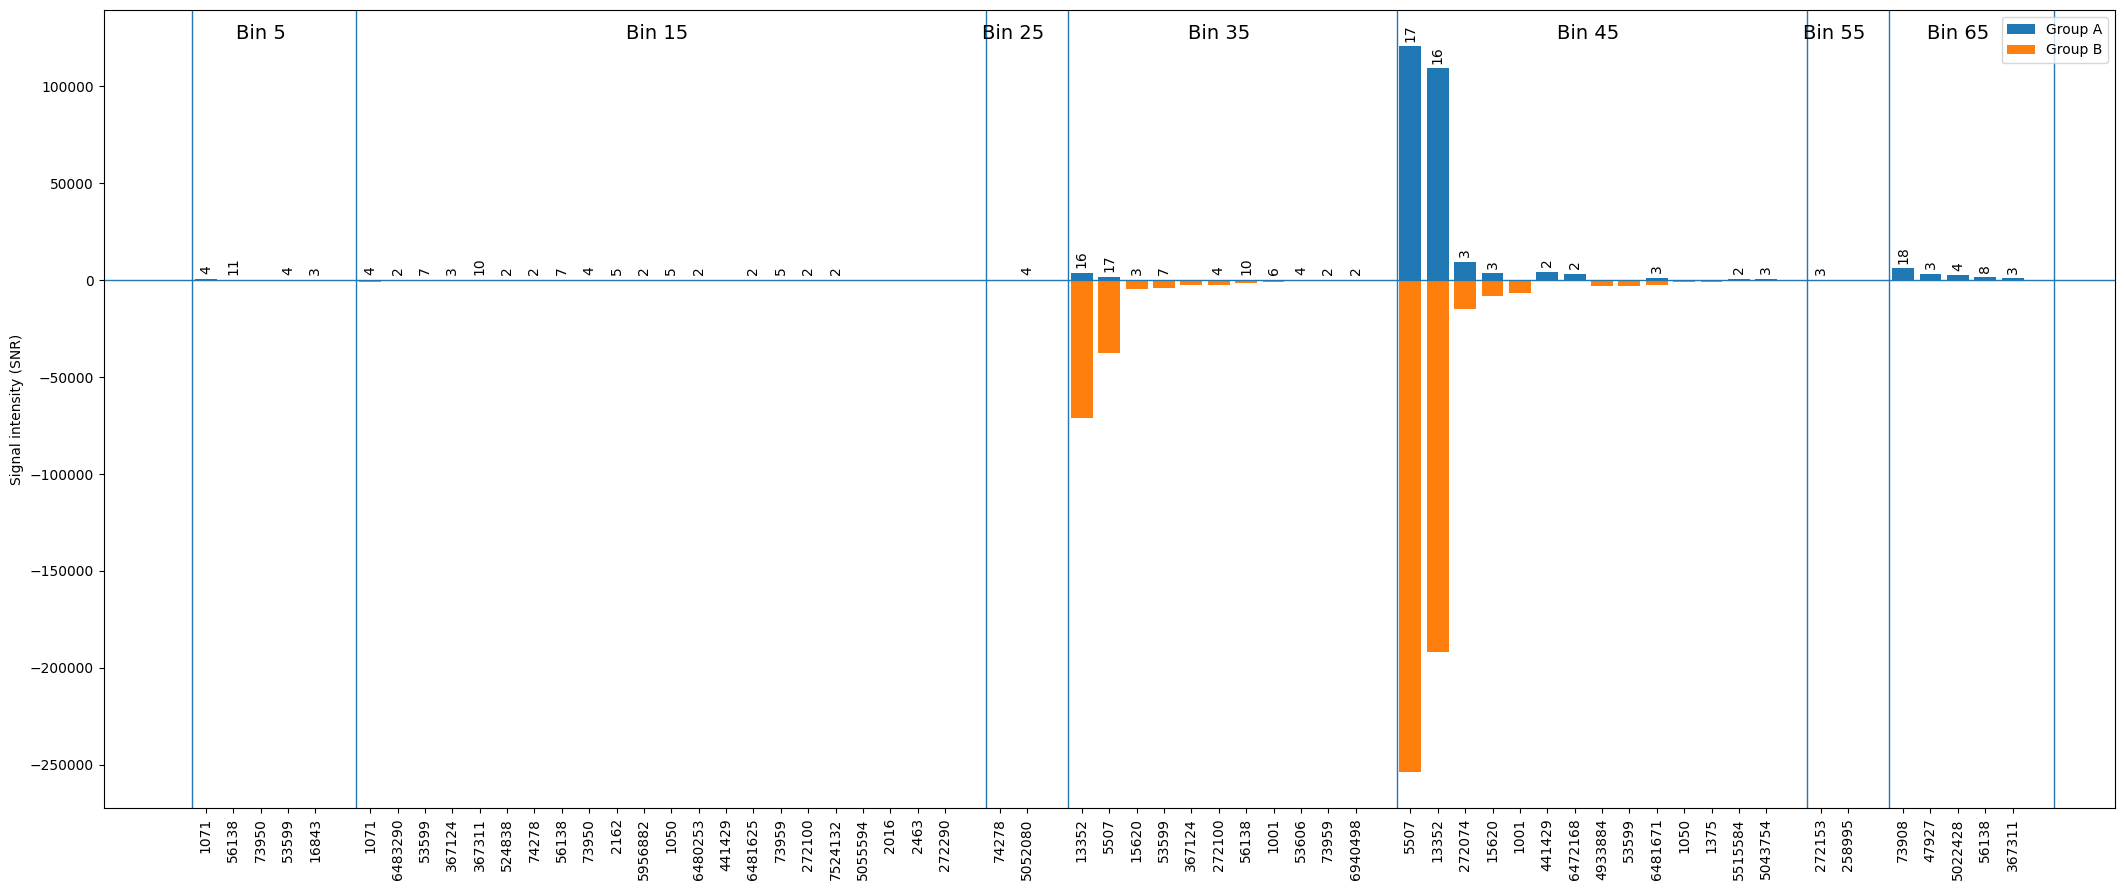

In [10]:
# Multi-bin mirror plot with inputs from two separate CSV files:
# Group A = first CSV, Group B = second CSV
# Proteoform IDs vertical, ".0" removed, hit numbers shown only for Group A.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------
# CONFIG
# --------------------
CSV_A = "F:/plot/groupa.csv"   # <-- replace with path to Group A CSV
CSV_B = "F:/plot/groupb.csv"   # <-- replace with path to Group B CSV
OUT_DIR = Path("mirror_plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_PNG = OUT_DIR / "combined_mirror_from_csvs.png"

# --------------------
# LOAD DATA
# --------------------
A = pd.read_csv(CSV_A)
B = pd.read_csv(CSV_B)

# Normalize column names
rename_map = {
    "Identified_proteoform": "proteoform",
    "PFR": "proteoform"
}
A = A.rename(columns=rename_map)
B = B.rename(columns=rename_map)

# Force required columns
A = A[["bin", "proteoform", "snr", "hit_number"]].copy()
B = B[["bin", "proteoform", "snr", "hit_number"]].copy()

A["group"] = "A"
B["group"] = "B"

# Clean up
for d in (A, B):
    d["snr"] = pd.to_numeric(d["snr"], errors="coerce")
    d["hit_number"] = pd.to_numeric(d["hit_number"], errors="coerce")

long_df = pd.concat([A, B], ignore_index=True)
long_df = long_df.dropna(subset=["bin", "proteoform", "snr"])

# Remove trailing ".0" in proteoform IDs
long_df["proteoform"] = long_df["proteoform"].astype(str).str.replace(r"\.0$", "", regex=True)

# --------------------
# BUILD CONCATENATED LAYOUT
# --------------------
bins_sorted = sorted(long_df["bin"].dropna().unique())

x_positions, heights_A, heights_B, hit_A, labels = [], [], [], [], []
bin_boundaries, bin_centers = [], []
cursor = 0
gap = 1
bar_width = 0.8

for b in bins_sorted:
    sub = long_df[long_df["bin"] == b].copy()
    agg = (
        sub.groupby(["group", "proteoform"], as_index=False)
           .agg(snr=("snr", "max"), hit_number=("hit_number", "max"))
    )

    pivot = agg.pivot(index="proteoform", columns="group", values="snr").fillna(0.0)
    pivot_hits = agg.pivot(index="proteoform", columns="group", values="hit_number")

    # Order by max intensity
    order = pivot.max(axis=1).sort_values(ascending=False).index
    pivot = pivot.loc[order]
    pivot_hits = pivot_hits.loc[order]

    n = len(pivot.index)
    if n == 0:
        continue

    xs = np.arange(cursor, cursor + n)
    x_positions.extend(xs.tolist())

    A_vals = pivot["A"].values if "A" in pivot.columns else np.zeros(n)
    B_vals = pivot["B"].values if "B" in pivot.columns else np.zeros(n)

    heights_A.extend(A_vals.tolist())
    heights_B.extend((-B_vals).tolist())   # negative for mirror

    if "A" in pivot_hits.columns:
        hit_A.extend(pivot_hits["A"].fillna(0).astype(int).values.tolist())
    else:
        hit_A.extend([0]*n)

    labels.extend(pivot.index.astype(str).tolist())

    bin_boundaries.append(cursor - 0.5)
    bin_centers.append(cursor + (n - 1) / 2)
    cursor += n + gap

bin_boundaries.append(cursor - gap - 0.5 + gap)

# --------------------
# PLOT MIRROR CHART
# --------------------
fig, ax = plt.subplots(figsize=(max(14, 0.35 * len(x_positions)), 9))

ax.bar(x_positions, heights_A, width=bar_width, label="Group A")
ax.bar(x_positions, heights_B, width=bar_width, label="Group B")

# Annotate hit numbers for Group A only (slightly above bar)
offset = 0.02 * (max(heights_A) if heights_A else 1.0)
for xi, ya, h in zip(x_positions, heights_A, hit_A):
    if ya and not np.isnan(ya):
        ax.text(xi, ya + offset, str(h), ha="center", va="bottom", fontsize=10, rotation=90)

# X tick labels = proteoform IDs (vertical)
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=90, ha="center", fontsize=10)
fig.subplots_adjust(bottom=0.28)   # <-- more room for vertical IDs

# Bin separators and titles
for xb in bin_boundaries:
    ax.axvline(x=xb, linewidth=1)
ymin, ymax = ax.get_ylim()
for c, b in zip(bin_centers, bins_sorted):
    ax.text(c, ymax * 0.95, f"Bin {b}", ha="center", va="top", fontsize=14)

ax.axhline(0, linewidth=1)
ax.set_ylabel("Signal intensity (SNR)")
#ax.set_xlabel("Proteoforms (IDs vertical)")
#ax.set_title("Mirror plot across all bins — A (top, hit # shown) vs B (bottom)")
ax.legend()
fig.tight_layout()

fig.savefig(OUTPUT_PNG, dpi=150, bbox_inches="tight")
plt.show()


using the unknowns with minimum SNR

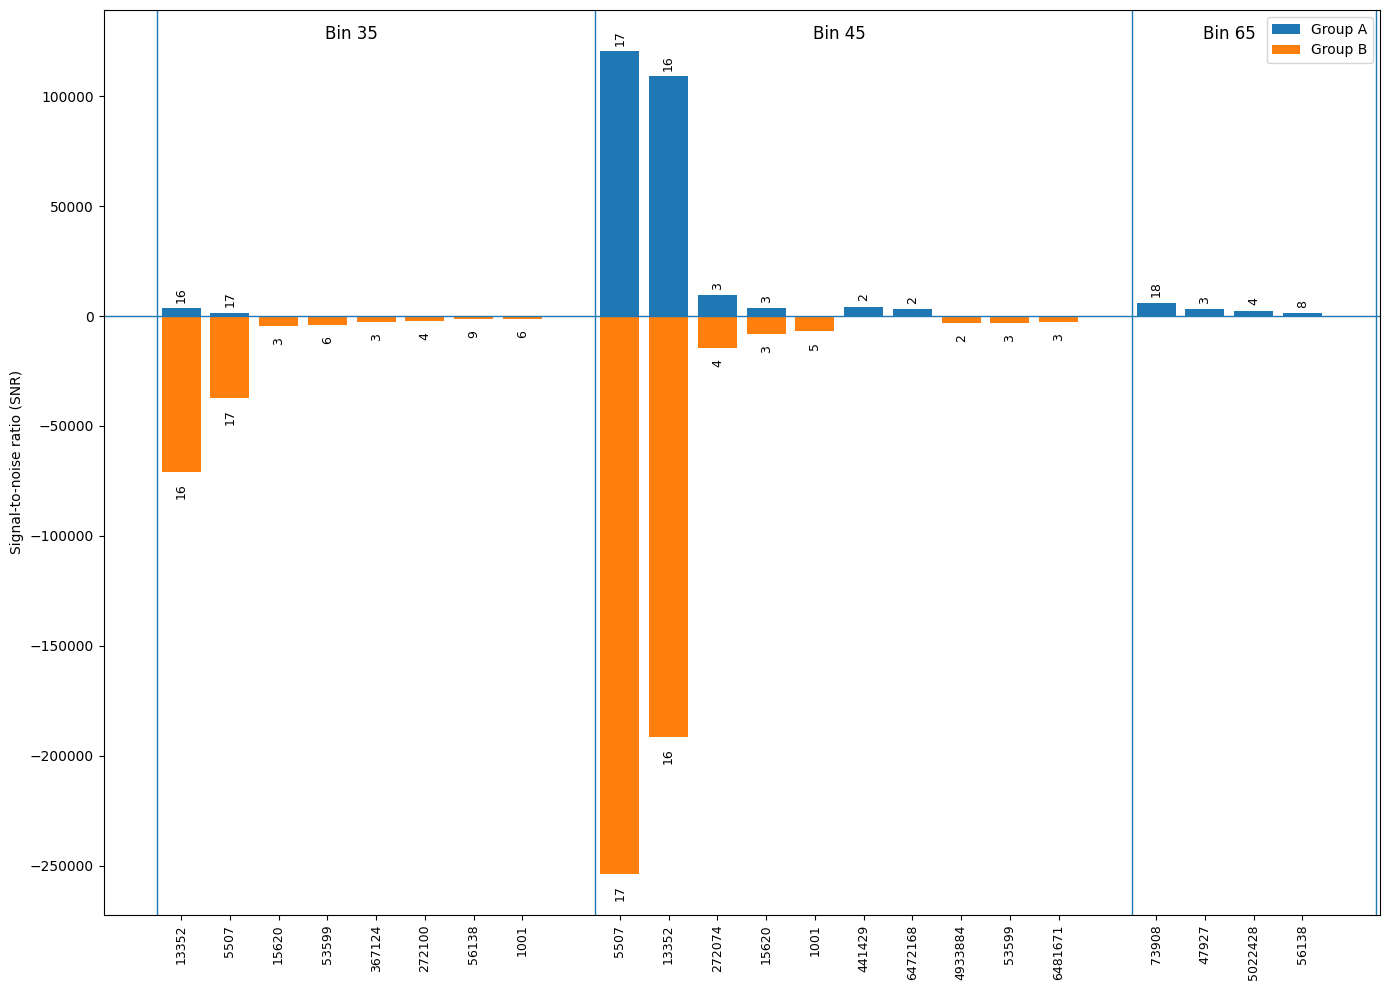

Saved → F:\plot\A_vs_B_mirror_sorted.png


In [2]:
# Mirror plot (A on top, B mirrored below) from a single CSV.
# - Groups inferred from replicate's first letter ('A*' -> A, 'B*' -> B)
# - MIN_SNR hard-coded
# - Proteoforms within each bin sorted by SNR (descending)
# - hit_number kept as strings (e.g., "20_10"), annotated above/below bars.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# --------------------
# CONFIG
# --------------------
IN_DIR   = Path(r"F:/plot")
OUT_DIR  = Path(r"F:/plot")
CSV_IN   = IN_DIR / "annotated.csv"
OUTPUT_PNG = OUT_DIR / "A_vs_B_mirror_sorted.png"

MIN_SNR = 1000.0  # hard-coded minimum SNR

# --------------------
# HELPERS
# --------------------
_hit_re = re.compile(r"^\s*(\d+)(?:_(\d+))?(?:_(\d+))?\s*$")

def parse_hit_token(token: str):
    if not isinstance(token, str):
        return None
    m = _hit_re.match(token)
    if not m:
        return None
    return tuple(int(x) for x in m.groups() if x is not None)

def pick_best_hit(series: pd.Series):
    best_tuple, best_raw = None, None
    for val in series.dropna():
        sval = str(val)
        tup = parse_hit_token(sval)
        if tup is not None:
            if (best_tuple is None) or (tup > best_tuple):
                best_tuple, best_raw = tup, sval
        elif best_raw is None:
            best_raw = sval
    return best_raw

def first_letter_group(rep_val: str):
    if pd.isna(rep_val):
        return None
    s = str(rep_val).strip().upper()
    return "A" if s.startswith("A") else "B" if s.startswith("B") else None

# --------------------
# LOAD & CLEAN
# --------------------
df = pd.read_csv(CSV_IN)
df = df.rename(columns={"Identified_proteoform": "proteoform", "PFR": "proteoform"})

df["bin"] = pd.to_numeric(df.get("bin"), errors="coerce")
df["snr"] = pd.to_numeric(df.get("snr"), errors="coerce")
df["group"] = df.get("replicate").apply(first_letter_group)

df = df.dropna(subset=["bin", "proteoform", "snr", "group"])
df = df[df["group"].isin(["A", "B"])]
df = df[df["snr"] >= MIN_SNR].copy()
df["proteoform"] = df["proteoform"].astype(str).str.replace(r"\.0$", "", regex=True)

if df.empty:
    raise SystemExit(f"No data left after filtering (MIN_SNR={MIN_SNR}).")

# --------------------
# AGGREGATE
# --------------------
agg = (
    df.groupby(["bin", "proteoform", "group"], as_index=False)
      .agg(snr=("snr", "max"), hit_number=("hit_number", pick_best_hit))
)

# --------------------
# BUILD CONCATENATED LAYOUT
# --------------------
bins_sorted = sorted(agg["bin"].unique())
x_positions, labels, bin_boundaries, bin_centers = [], [], [], []
A_heights, B_heights, A_hits, B_hits = [], [], [], []

cursor = 0
gap = 1
bar_width = 0.8

for b in bins_sorted:
    sub = agg[agg["bin"] == b].copy()
    
    # Sort proteoforms in this bin by max SNR across groups
    order = (
        sub.groupby("proteoform")["snr"]
           .max()
           .sort_values(ascending=False)
           .index
           .tolist()
    )
    
    subA = sub[sub["group"] == "A"].set_index("proteoform")
    subB = sub[sub["group"] == "B"].set_index("proteoform")
    
    n = len(order)
    xs = np.arange(cursor, cursor + n)
    
    for p in order:
        if p in subA.index:
            A_heights.append(float(subA.loc[p, "snr"]))
            A_hits.append(subA.loc[p, "hit_number"])
        else:
            A_heights.append(0.0)
            A_hits.append("")
        
        if p in subB.index:
            B_heights.append(-float(subB.loc[p, "snr"]))  # mirror negative
            B_hits.append(subB.loc[p, "hit_number"])
        else:
            B_heights.append(0.0)
            B_hits.append("")
    
    x_positions.extend(xs.tolist())
    labels.extend(order)
    bin_boundaries.append(cursor - 0.5)
    bin_centers.append(cursor + (n - 1) / 2)
    cursor += n + gap

if x_positions:
    bin_boundaries.append(cursor - gap - 0.5 + gap)

# --------------------
# PLOT
# --------------------
fig, ax = plt.subplots(figsize=(max(14, 0.35 * len(x_positions)), 10))
ax.bar(x_positions, A_heights, width=bar_width, label="Group A")
ax.bar(x_positions, B_heights, width=bar_width, label="Group B")

pos_offset = 0.02 * max(1.0, max(A_heights, default=1.0))
neg_offset = 0.02 * max(1.0, abs(min(B_heights, default=-1.0)))

for i, x in enumerate(x_positions):
    if A_heights[i]:
        ax.text(x, A_heights[i] + pos_offset, str(A_hits[i]), 
                ha="center", va="bottom", fontsize=9, rotation=90)
    if B_heights[i]:
        ax.text(x, B_heights[i] - neg_offset, str(B_hits[i]),
                ha="center", va="top", fontsize=9, rotation=90)

ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=90, fontsize=9)
fig.subplots_adjust(bottom=0.30)

for xb in bin_boundaries:
    ax.axvline(x=xb, linewidth=1)
ymin, ymax = ax.get_ylim()
for c, b in zip(bin_centers, bins_sorted):
    ax.text(c, ymax * 0.95, f"Bin {int(b)}", ha="center", va="top", fontsize=12)

ax.axhline(0, linewidth=1)
ax.set_ylabel("Signal-to-noise ratio (SNR)")
#ax.set_title(f"A vs B Mirror Plot by Proteoform (sorted by SNR, MIN_SNR ≥ {MIN_SNR})")
ax.legend(loc="upper right")


fig.tight_layout()
fig.savefig(OUTPUT_PNG, dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved → {OUTPUT_PNG}")


unkown PFRs based on top n number of PFRs

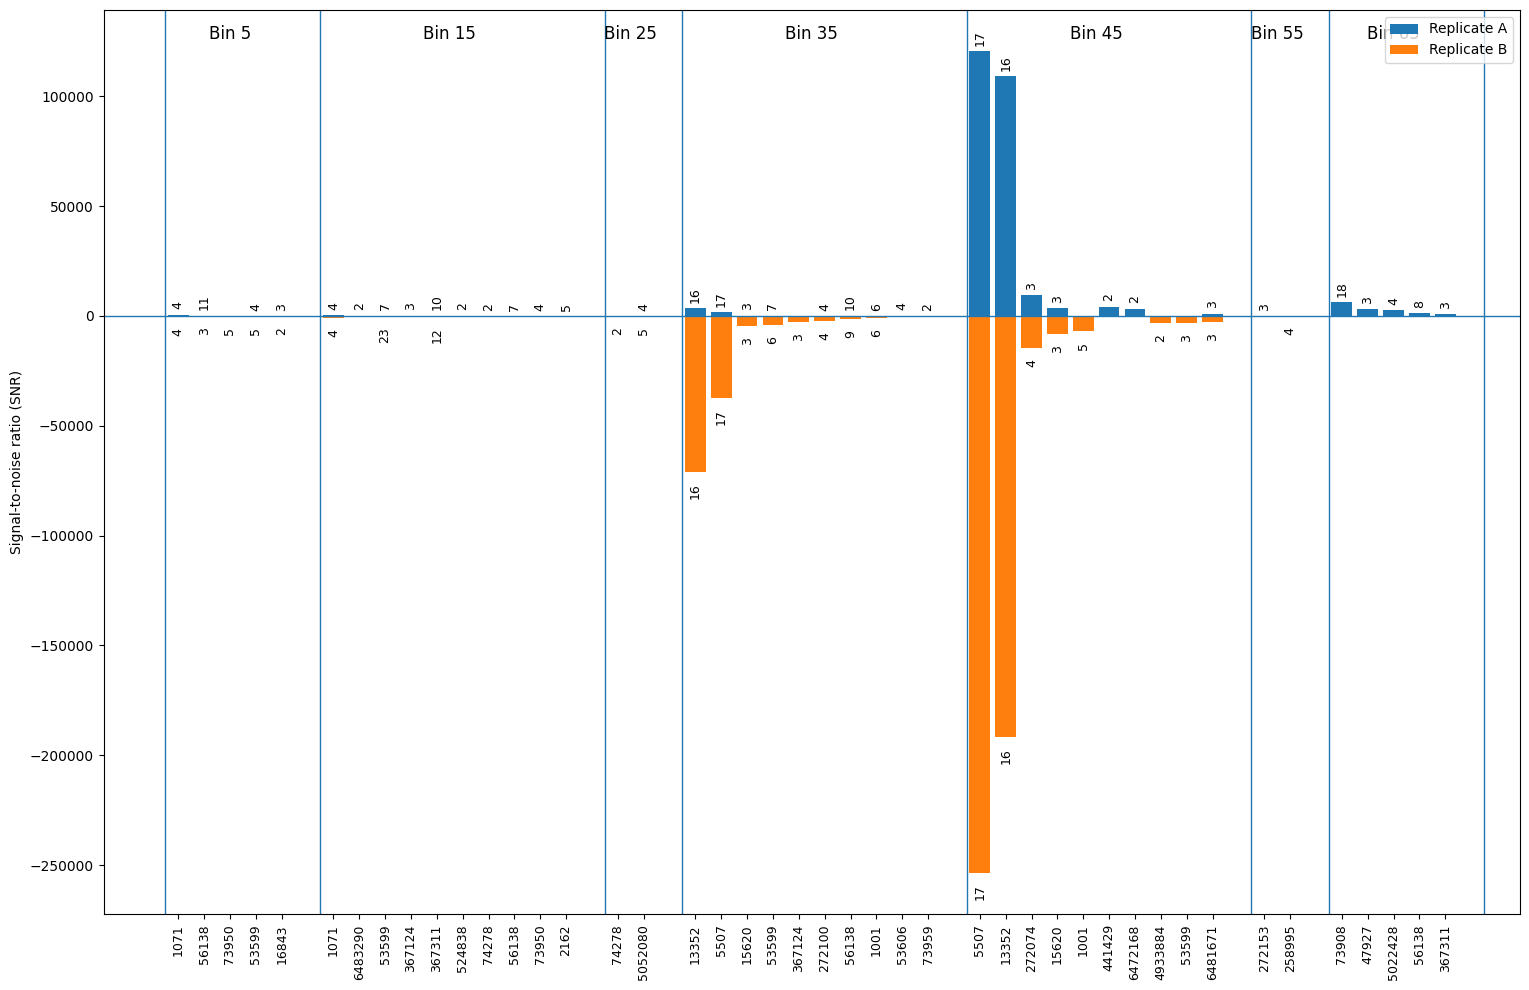

Saved → F:\plot\A_vs_B_mirror_sorted_topk.png


In [3]:
# Mirror plot (A on top, B mirrored below) from a single CSV.
# - Group comes directly from "replicate" column (values "A" or "B")
# - Instead of MIN_SNR filtering, select the TOP_K most abundant proteoforms (by max SNR) per bin
# - Proteoforms within each bin sorted by SNR (descending)
# - hit_number kept as strings (e.g., "20_10"), annotated above/below bars.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# --------------------
# CONFIG
# --------------------
IN_DIR   = Path(r"F:/plot")
OUT_DIR  = Path(r"F:/plot")
CSV_IN   = IN_DIR / "annotated.csv"
OUTPUT_PNG = OUT_DIR / "A_vs_B_mirror_sorted_topk.png"

TOP_K = 10   # number of top proteoforms per bin to show

# --------------------
# HELPERS
# --------------------
_hit_re = re.compile(r"^\s*(\d+)(?:_(\d+))?(?:_(\d+))?\s*$")

def parse_hit_token(token: str):
    if not isinstance(token, str):
        return None
    m = _hit_re.match(token)
    if not m:
        return None
    return tuple(int(x) for x in m.groups() if x is not None)

def pick_best_hit(series: pd.Series):
    best_tuple, best_raw = None, None
    for val in series.dropna():
        sval = str(val)
        tup = parse_hit_token(sval)
        if tup is not None:
            if (best_tuple is None) or (tup > best_tuple):
                best_tuple, best_raw = tup, sval
        elif best_raw is None:
            best_raw = sval
    return best_raw

# --------------------
# LOAD & CLEAN
# --------------------
OUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(CSV_IN)
df = df.rename(columns={"Identified_proteoform": "proteoform", "PFR": "proteoform"})

df["bin"] = pd.to_numeric(df.get("bin"), errors="coerce")
df["snr"] = pd.to_numeric(df.get("snr"), errors="coerce")
df["group"] = df["replicate"].astype(str).str.upper().str.strip()

df = df.dropna(subset=["bin", "proteoform", "snr", "group"])
df = df[df["group"].isin(["A", "B"])].copy()
df["proteoform"] = df["proteoform"].astype(str).str.replace(r"\.0$", "", regex=True)

if df.empty:
    raise SystemExit("No data left after initial cleaning (check CSV columns and values).")

# --------------------
# AGGREGATE
# --------------------
agg = (
    df.groupby(["bin", "proteoform", "group"], as_index=False)
      .agg(snr=("snr", "max"), hit_number=("hit_number", pick_best_hit))
)

# --------------------
# BUILD CONCATENATED LAYOUT WITH TOP-K PER BIN
# --------------------
bins_sorted = sorted(agg["bin"].unique())
x_positions, labels, bin_boundaries, bin_centers = [], [], [], []
A_heights, B_heights, A_hits, B_hits = [], [], [], []

cursor = 0
gap = 1
bar_width = 0.8

for b in bins_sorted:
    sub = agg[agg["bin"] == b].copy()

    # Sort proteoforms in this bin by max SNR across groups (desc)
    order_all = (
        sub.groupby("proteoform")["snr"]
           .max()
           .sort_values(ascending=False)
           .index
           .tolist()
    )
    # Keep only top-K
    order = order_all[:TOP_K]

    subA = sub[sub["group"] == "A"].set_index("proteoform")
    subB = sub[sub["group"] == "B"].set_index("proteoform")

    n = len(order)
    xs = np.arange(cursor, cursor + n)

    for p in order:
        if p in subA.index:
            A_heights.append(float(subA.loc[p, "snr"]))
            A_hits.append(subA.loc[p, "hit_number"])
        else:
            A_heights.append(0.0)
            A_hits.append("")
        if p in subB.index:
            B_heights.append(-float(subB.loc[p, "snr"]))  # mirror negative
            B_hits.append(subB.loc[p, "hit_number"])
        else:
            B_heights.append(0.0)
            B_hits.append("")

    x_positions.extend(xs.tolist())
    labels.extend(order)
    bin_boundaries.append(cursor - 0.5)
    bin_centers.append(cursor + (n - 1) / 2 if n > 0 else cursor)
    cursor += n + gap

if x_positions:
    bin_boundaries.append(cursor - gap - 0.5 + gap)

# --------------------
# PLOT
# --------------------
fig, ax = plt.subplots(figsize=(max(14, 0.35 * len(x_positions)), 10))
ax.bar(x_positions, A_heights, width=bar_width, label="Replicate A")
ax.bar(x_positions, B_heights, width=bar_width, label="Replicate B")

pos_offset = 0.02 * max(1.0, max(A_heights, default=1.0))
neg_offset = 0.02 * max(1.0, abs(min(B_heights, default=-1.0)))

for i, x in enumerate(x_positions):
    if A_heights[i]:
        ax.text(x, A_heights[i] + pos_offset, str(A_hits[i]) if A_hits[i] else "",
                ha="center", va="bottom", fontsize=9, rotation=90)
    if B_heights[i]:
        ax.text(x, B_heights[i] - neg_offset, str(B_hits[i]) if B_hits[i] else "",
                ha="center", va="top", fontsize=9, rotation=90)

ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=90, fontsize=9)
fig.subplots_adjust(bottom=0.30)

for xb in bin_boundaries:
    ax.axvline(x=xb, linewidth=1)

ymin, ymax = ax.get_ylim()
for c, b in zip(bin_centers, bins_sorted):
    if np.isfinite(c):
        ax.text(c, ymax * 0.95, f"Bin {int(b)}", ha="center", va="top", fontsize=12)

ax.axhline(0, linewidth=1)
ax.set_ylabel("Signal-to-noise ratio (SNR)")
#ax.set_title(f"A vs B Mirror Plot by Proteoform (Top {TOP_K} per bin, sorted by SNR)")
ax.legend(loc="upper right")

fig.tight_layout()
fig.savefig(OUTPUT_PNG, dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved → {OUTPUT_PNG}")


plots all the conditions with the top n

In [4]:
# Mirror plots (A on top, B mirrored below) from a single CSV,
# split by regulation (upregulated, downregulated) for EACH experiment.
#
# - Uses column "replicate" directly as group (values "A" or "B")
# - For every (experiment, regulation) subset, creates a mirror plot
# - Within each bin, keeps only TOP_K most abundant proteoforms by max SNR
# - Proteoforms sorted by SNR (descending)
# - hit_number kept as strings (e.g., "20_10"), annotated above/below bars

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# --------------------
# CONFIG
# --------------------
IN_DIR   = Path(r"F:/test/neuro/")
OUT_DIR  = Path(r"F:/test/neuro/mirror_by_regulation")
CSV_IN   = IN_DIR / "report.csv"

TOP_K = 10  # number of top proteoforms per bin to show

# --------------------
# HELPERS
# --------------------
_hit_re = re.compile(r"^\s*(\d+)(?:_(\d+))?(?:_(\d+))?\s*$")

def parse_hit_token(token: str):
    if not isinstance(token, str):
        return None
    m = _hit_re.match(token)
    if not m:
        return None
    return tuple(int(x) for x in m.groups() if x is not None)

def pick_best_hit(series: pd.Series):
    best_tuple, best_raw = None, None
    for val in series.dropna():
        sval = str(val)
        tup = parse_hit_token(sval)
        if tup is not None:
            if (best_tuple is None) or (tup > best_tuple):
                best_tuple, best_raw = tup, sval
        elif best_raw is None:
            best_raw = sval
    return best_raw

def norm_regulation(val) -> str | None:
    """
    Normalize regulation labels to 'upregulated' or 'downregulated'.
    Returns None for anything else (those rows will be ignored).
    """
    if pd.isna(val):
        return None
    s = str(val).strip().lower()
    s = s.replace("-", "").replace("_", "").replace(" ", "")
    if s.startswith("up"):
        return "upregulated"
    if s.startswith("down"):
        return "downregulated"
    return None

def sanitize_for_path(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", s)

def make_mirror_plot(df_sub: pd.DataFrame, exp_name: str, reg_name: str, top_k: int, out_dir: Path):
    """
    Create one mirror plot (A vs B) for the given subset dataframe df_sub,
    which must already be filtered to a single (experiment, regulation).
    """
    if df_sub.empty:
        return None

    # Aggregate to max SNR per (bin, proteoform, group) and pick best hit_number token
    agg = (
        df_sub.groupby(["bin", "proteoform", "group"], as_index=False)
              .agg(snr=("snr", "max"), hit_number=("hit_number", pick_best_hit))
    )

    if agg.empty:
        return None

    # Build concatenated layout with TOP-K per bin
    bins_sorted = sorted(agg["bin"].unique())
    x_positions, labels, bin_boundaries, bin_centers = [], [], [], []
    A_heights, B_heights, A_hits, B_hits = [], [], [], []

    cursor = 0
    gap = 1
    bar_width = 0.8

    for b in bins_sorted:
        sub = agg[agg["bin"] == b].copy()

        # Sort proteoforms in this bin by max SNR across groups (desc)
        order_all = (
            sub.groupby("proteoform")["snr"]
               .max()
               .sort_values(ascending=False)
               .index
               .tolist()
        )
        order = order_all[:top_k]

        subA = sub[sub["group"] == "A"].set_index("proteoform")
        subB = sub[sub["group"] == "B"].set_index("proteoform")

        n = len(order)
        xs = np.arange(cursor, cursor + n)

        for p in order:
            if p in subA.index:
                A_heights.append(float(subA.loc[p, "snr"]))
                A_hits.append(subA.loc[p, "hit_number"])
            else:
                A_heights.append(0.0)
                A_hits.append("")
            if p in subB.index:
                B_heights.append(-float(subB.loc[p, "snr"]))  # mirror negative
                B_hits.append(subB.loc[p, "hit_number"])
            else:
                B_heights.append(0.0)
                B_hits.append("")

        x_positions.extend(xs.tolist())
        labels.extend(order)
        bin_boundaries.append(cursor - 0.5)
        bin_centers.append(cursor + (n - 1) / 2 if n > 0 else cursor)
        cursor += n + gap

    if not x_positions:
        return None

    bin_boundaries.append(cursor - gap - 0.5 + gap)

    # PLOT
    fig, ax = plt.subplots(figsize=(max(14, 0.35 * len(x_positions)), 10))
    ax.bar(x_positions, A_heights, width=bar_width, label="Group A")
    ax.bar(x_positions, B_heights, width=bar_width, label="Group B")

    pos_offset = 0.02 * max(1.0, max(A_heights, default=1.0))
    neg_offset = 0.02 * max(1.0, abs(min(B_heights, default=-1.0)))

    for i, x in enumerate(x_positions):
        if A_heights[i]:
            ax.text(x, A_heights[i] + pos_offset, str(A_hits[i]) if A_hits[i] else "",
                    ha="center", va="bottom", fontsize=9, rotation=90)
        if B_heights[i]:
            ax.text(x, B_heights[i] - neg_offset, str(B_hits[i]) if B_hits[i] else "",
                    ha="center", va="top", fontsize=9, rotation=90)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels, rotation=90, fontsize=9)
    fig.subplots_adjust(bottom=0.30)

    for xb in bin_boundaries:
        ax.axvline(x=xb, linewidth=1)

    ymin, ymax = ax.get_ylim()
    for c, b in zip(bin_centers, bins_sorted):
        if np.isfinite(c):
            ax.text(c, ymax * 0.95, f"Bin {int(b)}", ha="center", va="top", fontsize=12)

    ax.axhline(0, linewidth=1)
    ax.set_ylabel("Signal-to-noise ratio (SNR)")
    ax.set_title(f"{exp_name} — {reg_name.capitalize()} (Top {top_k} per bin, by SNR)")
    ax.legend(loc="upper right")

    fig.tight_layout()

    out_dir.mkdir(parents=True, exist_ok=True)
    out_name = f"mirror_{sanitize_for_path(exp_name)}_{reg_name}_top{top_k}.png"
    out_path = out_dir / out_name
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    return out_path

# --------------------
# LOAD & CLEAN
# --------------------
OUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(CSV_IN)
df = df.rename(columns={"Identified_proteoform": "proteoform", "PFR": "proteoform"})

# Required columns to numeric/clean
df["bin"] = pd.to_numeric(df.get("bin"), errors="coerce")
df["snr"] = pd.to_numeric(df.get("snr"), errors="coerce")
df["group"] = df["replicate"].astype(str).str.upper().str.strip()

# Normalize proteoform labels (drop trailing ".0")
df["proteoform"] = df["proteoform"].astype(str).str.replace(r"\.0$", "", regex=True)

# Normalize regulation
df["regulation_norm"] = df["regulation"].apply(norm_regulation)

# Normalize experiment labels to strings (for grouping and filenames)
df["experiment"] = df["experiment"].astype(str).str.strip()

# Drop unusable rows
df = df.dropna(subset=["bin", "proteoform", "snr", "group", "experiment", "regulation_norm"])
df = df[df["group"].isin(["A", "B"])]

if df.empty:
    raise SystemExit("No data left after cleaning (check CSV columns and values).")

# --------------------
# LOOP OVER (experiment, regulation)
# --------------------
outputs = []
for exp_name in sorted(df["experiment"].unique()):
    for reg_name in ("upregulated", "downregulated"):
        sub = df[(df["experiment"] == exp_name) & (df["regulation_norm"] == reg_name)].copy()
        if sub.empty:
            continue
        out = make_mirror_plot(sub, exp_name=exp_name, reg_name=reg_name, top_k=TOP_K, out_dir=OUT_DIR)
        if out is not None:
            print(f"Saved → {out}")
            outputs.append(str(out))

if not outputs:
    print("No plots were generated (no matching data for the requested (experiment, regulation) subsets).")


Saved → F:\test\neuro\mirror_by_regulation\mirror_1vs0_upregulated_top10.png
Saved → F:\test\neuro\mirror_by_regulation\mirror_1vs0_downregulated_top10.png
